<div >
    <img src = "../banner/banner_ML_UNLP_1900_200.png" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/ML_UNLP_Lectures/blob/main/Week03/Notebook_SS03_arboles.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# CARTs, Bagging, Random Forests y Boosting

### Prediciendo precios de propiedades

Nuestro objetivo hoy es construir un modelo para predecir los precios de la vivienda. Del artículo histórico de Rosen "Hedonic Prices and Implicit Markets: Product Differentiation in Pure Competition" (1974), sabemos que un vector de sus características describe un bien diferenciado.

En el caso de una casa, estas características pueden incluir atributos estructurales (por ejemplo, número de dormitorios), amenidades, etc.. Así, podemos escribir el precio de mercado de la casa como:

$$
Price=f(atributos\,estructurales,amenidades,...)
$$


Sin embargo, la teoría de Rosen no nos dice mucho sobre la forma funcional de $f$.

# CARTS

Let's load the modules:

In [1]:
import numpy as np
import pandas as pd

 And the toy data set:

In [2]:
db= pd.read_csv('https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/toy_houses.csv')

In [3]:
db.head()

,price,habitaciones,DCBD
0,162753.088698,3,1.190307
1,73131.298210,0,1.910839
2,162757.453241,2,1.227716
3,73127.751725,1,1.824990
4,73128.712716,0,1.915576


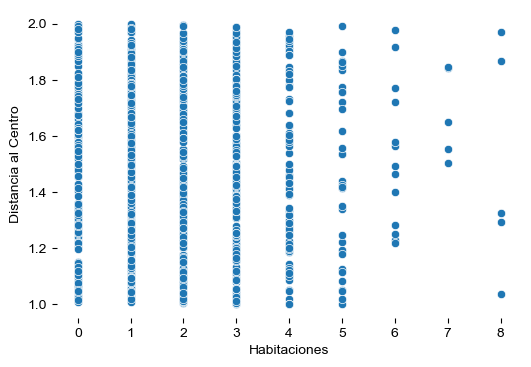

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the scatter plot
plt.figure(figsize=(6, 4))
sns.scatterplot(data=db, x='habitaciones', y='DCBD')

# Scale x-axis and set labels
plt.xticks(np.arange(0, 9, 1))
plt.xlabel("Habitaciones")
plt.ylabel("Distancia al Centro")

# Apply classic theme
sns.set_theme(style="whitegrid")

# Adjust text size and remove legend
plt.rc('font', size=20)
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()


### Algorithm


-  Datos: $y_{n\times 1}$  y $X_{n\times k}$ 

-  Definiciones

      -  *j* es la variable que parte el espacio 
      - *s* es el punto de partición


-  Definimos los siguientes semiplanos

\begin{align}
R_1(j,s)=\{X|X_j\leq s\} \,\,\, \& \,\,\, R_2(j,s)=\{X|X_j > s\}
\end{align}

-  *El problema*: buscar la variable de partición $X_j$ y el punto $s$ de forma tal que 


\begin{align}
\underset{j,s}{min} \left[ \underset{y_{R_1}}{min}\sum_{x_i\in R_1(j,s)}(y-y_{R_1})^2+ \underset{y_{R_2}}{min}\sum_{x_i\in R_2(j,s)}(y-y_{R_2})^2\right]
\end{align}



#### Algorithm by hand ("artesanal")

1. Iniciemos por DBCD

In [5]:

# Initialize an empty list to store MSE values
MSE_dbcd = []

# Loop through the specified range
for i in np.arange(1.25, 2, 0.25):
    # Region 1
    R1 = db[db['DCBD'] <= i]
    yr1 = R1['price'].mean()
    MSEr1 = ((R1['price'] - yr1) ** 2).mean() 

    # Region 2
    R2 = db[db['DCBD'] > i]
    yr2 = R2['price'].mean()
    MSEr2 = ((R2['price'] - yr2) ** 2).mean()

    # Store the sum of MSEs
    MSE_dbcd.append(MSEr1 + MSEr2)

# Output the result
MSE_dbcd


[1619184820.8433454, 144556602.21126744, 1612314034.3929405]

2. Luego por Habitaciones

In [6]:

# Initialize an empty list to store MSE values
MSE_hab = []

# Loop through the specified range
for i in range(9):  # 0 to 8 inclusive
    # Region 1
    R1 = db[db['habitaciones'] <= i]
    yr1 = R1['price'].mean()
    MSEr1 = ((R1['price'] - yr1) ** 2).mean() 

    # Region 2
    R2 = db[db['habitaciones'] > i]
    yr2 = R2['price'].mean()
    MSEr2 = ((R2['price'] - yr2) ** 2).mean() 

    # Store the sum of MSEs
    MSE_hab.append(MSEr1 + MSEr2)

# Output the result
MSE_hab

[3655836375.9277906,
 3478068099.638648,
 3029642858.8054256,
 2817877744.8144107,
 2778785039.236776,
 2740560656.0990343,
 2585869900.2908463,
 2703378640.1114693,
 nan]

**Mínimo?**

In [7]:
# Combine the MSE lists
MSE = MSE_dbcd + MSE_hab

# Find the minimum MSE and its index
min_MSE = min(MSE)
min_MSE_index = MSE.index(min_MSE) + 1  # Adding 1 because Python indexing starts at 0

# Output the minimum MSE and its index
print("Minimum MSE is at index:", min_MSE_index, "with a value of:", min_MSE)

# Output the entire MSE list
print("MSE values:", MSE)


Minimum MSE is at index: 2 with a value of: 144556602.21126744
MSE values: [1619184820.8433454, 144556602.21126744, 1612314034.3929405, 3655836375.9277906, 3478068099.638648, 3029642858.8054256, 2817877744.8144107, 2778785039.236776, 2740560656.0990343, 2585869900.2908463, 2703378640.1114693, nan]


#### Algorithm in Python

La principal implementación de árboles de regresión en `Python` está disponible en la librería `scikit-learn` a través de las clase `DecisionTreeRegressor`. Una característica importante para aquellos que han utilizado otras implementaciones es que, en `scikit-learn`, es necesario convertir las variables categóricas en variables dummy (one-hot-encoding)

In [8]:
from sklearn.tree import DecisionTreeRegressor

# Prepare the features (X) and target (y)
X = db[['DCBD', 'habitaciones']]
y = db['price']

# Create the decision tree model
mytree = DecisionTreeRegressor(max_leaf_nodes=3)

# Fit the model
mytree.fit(X, y)



DecisionTreeRegressor(max_leaf_nodes=3)

Una vez entrenado el árbol, se puede representar mediante la combinación de las funciones  `export_text()` y `plot_tree()`. 
 - La función `export_text()` la estructura del árbol  y valor medio de la variable respuesta en cada nodo.  
 - La función `plot_tree()` dibuja la estructura del árbol y muestra el número de observaciones y valor medio de la variable respuesta en cada nodo.

In [9]:
from sklearn.tree import export_text

texto_modelo = export_text(
                    decision_tree = mytree,
                    feature_names = list(X.columns)
               )
print(texto_modelo)

|--- DCBD <= 1.50
|   |--- value: [162754.67]
|--- DCBD >  1.50
|   |--- habitaciones <= 2.50
|   |   |--- value: [73130.58]
|   |--- habitaciones >  2.50
|   |   |--- value: [98716.14]



Profundidad del árbol: 2
Número de nodos terminales: 3


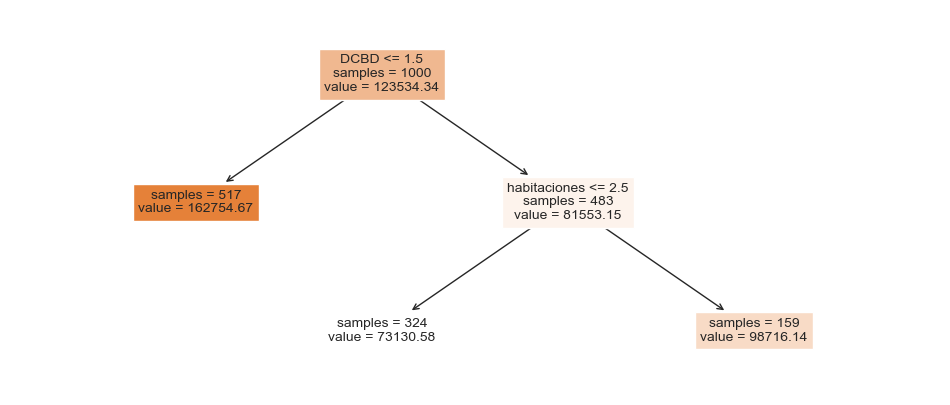

In [10]:
from sklearn.tree import plot_tree


# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 5))

print(f"Profundidad del árbol: {mytree.get_depth()}")
print(f"Número de nodos terminales: {mytree.get_n_leaves()}")

plot = plot_tree(
            decision_tree = mytree,
            feature_names = X.columns,
            class_names   = 'price',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )



##### With California housing data set

In [11]:
california_housing=pd.read_csv('https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/california_housing.csv')

1. longitude: A measure of how far west a house is; a higher value is farther west

2. latitude: A measure of how far north a house is; a higher value is farther north

3. housingMedianAge: Median age of a house within a block; a lower number is a newer building

4. totalRooms: Total number of rooms within a block

5. totalBedrooms: Total number of bedrooms within a block

6. population: Total number of people residing within a block

7. households: Total number of households, a group of people residing within a home unit, for a block

8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. medianHouseValue: Median house value for households within a block (measured in US Dollars)

10. oceanProximity: Location of the house w.r.t ocean/sea

In [12]:
california_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [13]:
california_housing.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [14]:
# drop the missing data
california_housing = california_housing.dropna()

In [15]:
# Extracting the data
X = california_housing.drop('median_house_value', axis = 1)  # Features
Y = california_housing['median_house_value']                 # Target


In [17]:
#tree_california_1 = DecisionTreeRegressor(max_leaf_nodes = 8).fit(X, y)

In [18]:
# Exporing the categorical data
california_housing['ocean_proximity'].unique()


array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [19]:
# Converting categorical values to numeric values using one-hot encoding
california_housing = pd.get_dummies(california_housing, columns= ['ocean_proximity'])

# Showing the data after Converting categorical values to numeric values
california_housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0,0,0,1,0


In [20]:
# Extracting the data
X2 = california_housing.drop('median_house_value', axis = 1)  # Features
Y = california_housing['median_house_value']                 # Target


In [21]:
X2.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [22]:
tree_california_2 = DecisionTreeRegressor(max_leaf_nodes = 8)

tree_california_2.fit(X2,Y)

DecisionTreeRegressor(max_leaf_nodes=8)

Profundidad del árbol: 4
Número de nodos terminales: 8


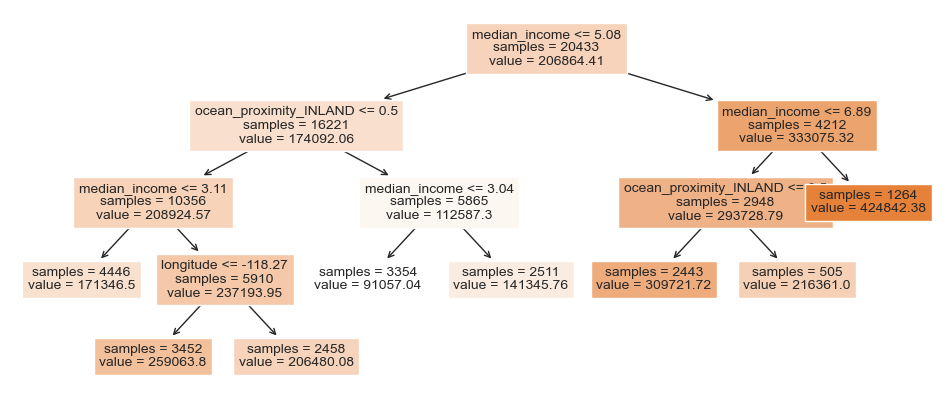

In [23]:
# Estructura del árbol creado
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(12, 5))

print(f"Profundidad del árbol: {tree_california_2.get_depth()}")
print(f"Número de nodos terminales: {tree_california_2.get_n_leaves()}")

plot = plot_tree(
            decision_tree = tree_california_2,
            feature_names = X2.columns,
            class_names   = 'median_house_value',
            filled        = True,
            impurity      = False,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )



### Sobreajuste

<div >
    <img src = "figures/tree_uba.png"  width="300" height="600"/>
</div>


`DecisionTreeRegressor` del módulo `sklearn.tree` tiene  hiperparámetros, que nos permitirán "controlar" el sobreajuste:

  - `max_depth`: profundidad máxima que puede alcanzar el árbol.

  - `max_leaf_nodes`: número máximo de nodos terminales.

  - `min_samples_leaf`: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento `ceil(min_samples_split * n_samples)`.

  
  - `ccp_alpha`=0.0 Cost complexity prunning
  
  - `random_state`: semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.

Como en todo estudio de regresión, no solo es importante ajustar el modelo, sino también cuantificar su capacidad para predecir nuevas observaciones. Para poder hacer la posterior evaluación, se dividen los datos en dos grupos, uno de entrenamiento y otro de test.


In [24]:
# División de los datos en train y test
# ------------------------------------------------------------------------------
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
                                        X2,
                                        Y,
                                        test_size=0.3,
                                        random_state = 1010101
                                    )

#### Fijar la profundidad del árbol.

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error


param_grid = {'max_depth': [1, 5, 10, 15,20]}

# Búsqueda por validación cruzada
grid_depth = GridSearchCV(
        # El árbol se crece al máximo posible para luego aplicar el pruning
        estimator = DecisionTreeRegressor(random_state  = 123),
        param_grid = param_grid,
        cv         = 5,
        refit      = True,
        scoring='neg_mean_squared_error',
        return_train_score = True
      )

grid_depth.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=123),
             param_grid={'max_depth': [1, 5, 10, 15, 20]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [26]:
# Mejor valor max_depth encontrado
# ------------------------------------------------------------------------------
grid_depth.best_params_

{'max_depth': 10}

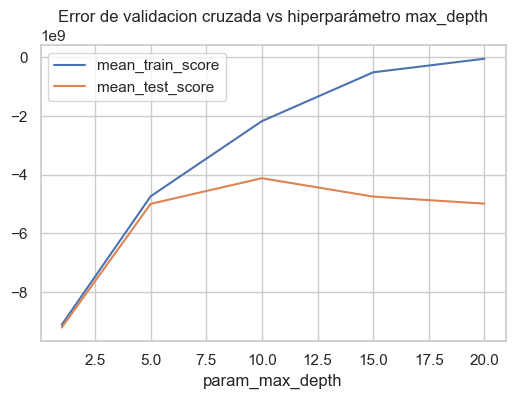

In [27]:

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid_depth.cv_results_)
scores.plot(x='param_max_depth', y='mean_train_score', ax=ax)
scores.plot(x='param_max_depth', y='mean_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro max_depth");

#### Cost complexity Prunning


\begin{align}
  C_{\alpha}(T)= \sum_{m=1}^{[T]}  \sum_{x_i\in R_m} (y_i-\hat{y}_m)^2 + \alpha [T]
\end{align}



##### Algoritmo completo

  - Hacemos crecer el árbol

  - Para un dado $\alpha$, aplicamos  *cost complexity pruning* 
    
  - Utilizamos K-fold cross-validation para elegir $\alpha$. 

  
Tenemos entonces una secuencia de subarboles para distintos valores de $\alpha$ 

Elegimos el $\alpha$ y el subárbol que tienen el menor error de predicción.



Para aplicar el proceso de pruning en `scikit-learn` es necesario indicar el argumento `ccp_alpha` que determina el grado de penalización por complejidad. Cuanto mayor es este valor, más agresivo el podado y menor el tamaño del árbol resultante. Dado que no hay forma de conocer de antemano el valor óptimo de `ccp_alpha`, se recurre a validación cruzada para identificarlo.

Aunque existen otras formas de indentificar árboles "optimos", por ejemplo identificando el valor de `max_depth` y `min_samples_split` mediante validación cruzada, el pruning puede generar mejores resultados.


In [28]:
# Pruning (const complexity pruning) por validación cruzada
# ------------------------------------------------------------------------------
# Valores de ccp_alpha evaluados
param_grid = {'ccp_alpha':np.linspace(1000000, 10000000, 10)}

# Búsqueda por validación cruzada
grid = GridSearchCV(
        # El árbol se crece al máximo posible para luego aplicar el pruning
        estimator = DecisionTreeRegressor(
                            max_depth         = None,
                            min_samples_split = 2,
                            min_samples_leaf  = 1,
                            random_state      = 123
                       ),
        param_grid = param_grid,
        cv         = 5,
        refit      = True,
        scoring='neg_mean_squared_error',
        return_train_score = True
      )

grid.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=123),
             param_grid={'ccp_alpha': array([ 1000000.,  2000000.,  3000000.,  4000000.,  5000000.,  6000000.,
        7000000.,  8000000.,  9000000., 10000000.])},
             return_train_score=True, scoring='neg_mean_squared_error')

In [29]:
# Mejor valor ccp_alpha encontrado
# ------------------------------------------------------------------------------
grid.best_params_


{'ccp_alpha': 6000000.0}

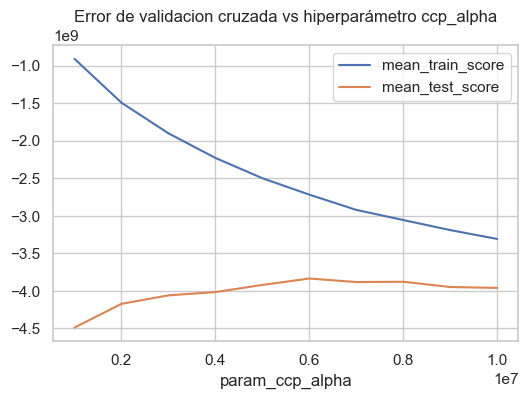

In [30]:

fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_ccp_alpha', y='mean_train_score', ax=ax)
scores.plot(x='param_ccp_alpha', y='mean_test_score', ax=ax)
ax.set_title("Error de validacion cruzada vs hiperparámetro ccp_alpha");



Una vez identificado el valor óptimo de `ccp_alpha`, se reentrena el árbol indicando este valor en sus argumentos. Si en el `GridSearchCV()` se indica `refit=True`, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en `.best_estimator_`.


In [31]:
# Estructura del árbol final
# ------------------------------------------------------------------------------
modelo_prunning = grid.best_estimator_
print(f"Profundidad del árbol: {modelo_prunning.get_depth()}")
print(f"Número de nodos terminales: {modelo_prunning.get_n_leaves()}")


Profundidad del árbol: 15
Número de nodos terminales: 146


#### Predicción  y evaluación del modelo


In [32]:
# Error de test del modelo max_depth
#-------------------------------------------------------------------------------
modelo_depth = grid_depth.best_estimator_
predicciones = modelo_depth.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 62584.627417678785


In [33]:
# Error de test del modelo final (tras aplicar pruning)
#-------------------------------------------------------------------------------
predicciones = modelo_prunning.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 61833.00273399615


### Comentarios sobre Árboles


#### Pros: 
  
    - Los árboles son muy fáciles de explicar a las personas (probablemente incluso más fáciles que la regresión lineal)

    - Los árboles se pueden trazar gráficamente y son fácilmente interpretados incluso por no expertos. Variables más importantes en la parte superior



#### Cons:
    
    - Si la estructura es lineal, CART no funciona bien
    
<div >
<img src = "figures/tree_vs_reg.png" />
</div>


    - Los árboles no son muy robustos 
    

# Random Forests

In [34]:
from sklearn.ensemble import RandomForestRegressor
import multiprocessing

In [35]:
# Creación del modelo
# ==============================================================================
modelo_forest = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 1,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo_forest.fit(X_train, y_train)

RandomForestRegressor(max_features=1, n_estimators=10, n_jobs=-1,
                      random_state=123)

### Predicción y evaluación del modelo

In [36]:
# Error de test del modelo inicial
# ==============================================================================
predicciones_forest = modelo_forest.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones_forest,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")



El error (rmse) de test es: 57625.14751646491


### Optimización de hiperparámetros

El modelo inicial se ha entrenado utilizando 10 árboles (n_estimators=10) y manteniendo el resto de hiperparámetros con su valor por defecto. Al ser hiperparámetros, no se puede saber de antemano cuál es el valor más adecuado, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada.

Los modelos Random Forest tienen la ventaja de disponer del Out-of-Bag error, lo que permite obtener una estimación del error de test sin recurrir a la validación cruzada, que es computacionalmente costosa. En la implementación de RandomForestRegressor, la métrica devuelta como oob_score es el 𝑅2, si se desea otra, se tiene que recurrir al método oob_decision_function_() para obtener las predicciones y con ellas calcular la métrica de interés. Para una explicación más detallada consultar: Grid search de modelos Random Forest con out-of-bag error y early stopping.

Cabe tener en cuenta que, cuando se busca el valor óptimo de un hiperparámetro con dos métricas distintas, el resultado obtenido raramente es el mismo. Lo importante es que ambas métricas identifiquen las mismas regiones de interés.



   La clase RandomForestRegressor del módulo sklearn.ensemble contiene varios hiperparámetros. De entre todos ellos, destacan aquellos que detienen el crecimiento de los árboles, los que controlan el número de árboles y predictores incluidos, y los que gestionan la paralelización:

   - `n_estimators`; número de árboles incluidos en el modelo.

   - `max_depth`: profundidad máxima que pueden alcanzar los árboles.

   - `min_samples_split`: número mínimo de observaciones que debe de tener un nodo para que pueda dividirse. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

   - `min_samples_leaf`: número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

   - `max_leaf_nodes`: número máximo de nodos terminales que pueden tener los árboles.

   - `max_features`: número de predictores considerados a en cada división. Puede ser:
        Un valor entero
        Una fracción del total de predictores..
        “sqrt”, raiz cuadrada del número total de predictores.
        “log2”, log2 del número total de predictores.
        None, utiliza todos los predictores.

   - `oob_score`: Si se calcula o no el out-of-bag R^2. Por defecto es False ya que aumenta el tiempo de entrenamiento.

   - `n_jobs`: número de cores empleados para el entrenamiento. En random forest los árboles se ajustan de forma independiente, por lo la paralelización reduce notablemente el tiempo de entrenamiento. Con -1 se utilizan todos los cores disponibles.

   - `random_state`: semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.



#### Número de árboles

En Random Forest, el número de árboles no es un hiperparámetro crítico en cuanto que, añadir árboles, solo puede hacer que mejorar el resultado. En Random Forest no se produce overfitting por exceso de árboles. Sin embargo, añadir árboles una vez que la mejora se estabiliza es una perdida te recursos computacionales.


In [37]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(10, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 1,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
  

Valor óptimo de n_estimators: 145


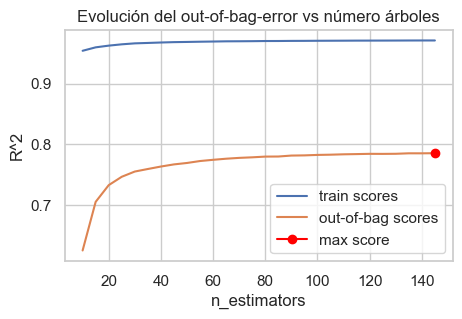

In [38]:
  
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")
warnings.filterwarnings('default')

#### Max features

El valor de `max_features` es uno de los hiperparámetros más importantes de random forest, ya que es el que permite controlar cuánto se decorrelacionan los árboles entre sí.

<Axes: >

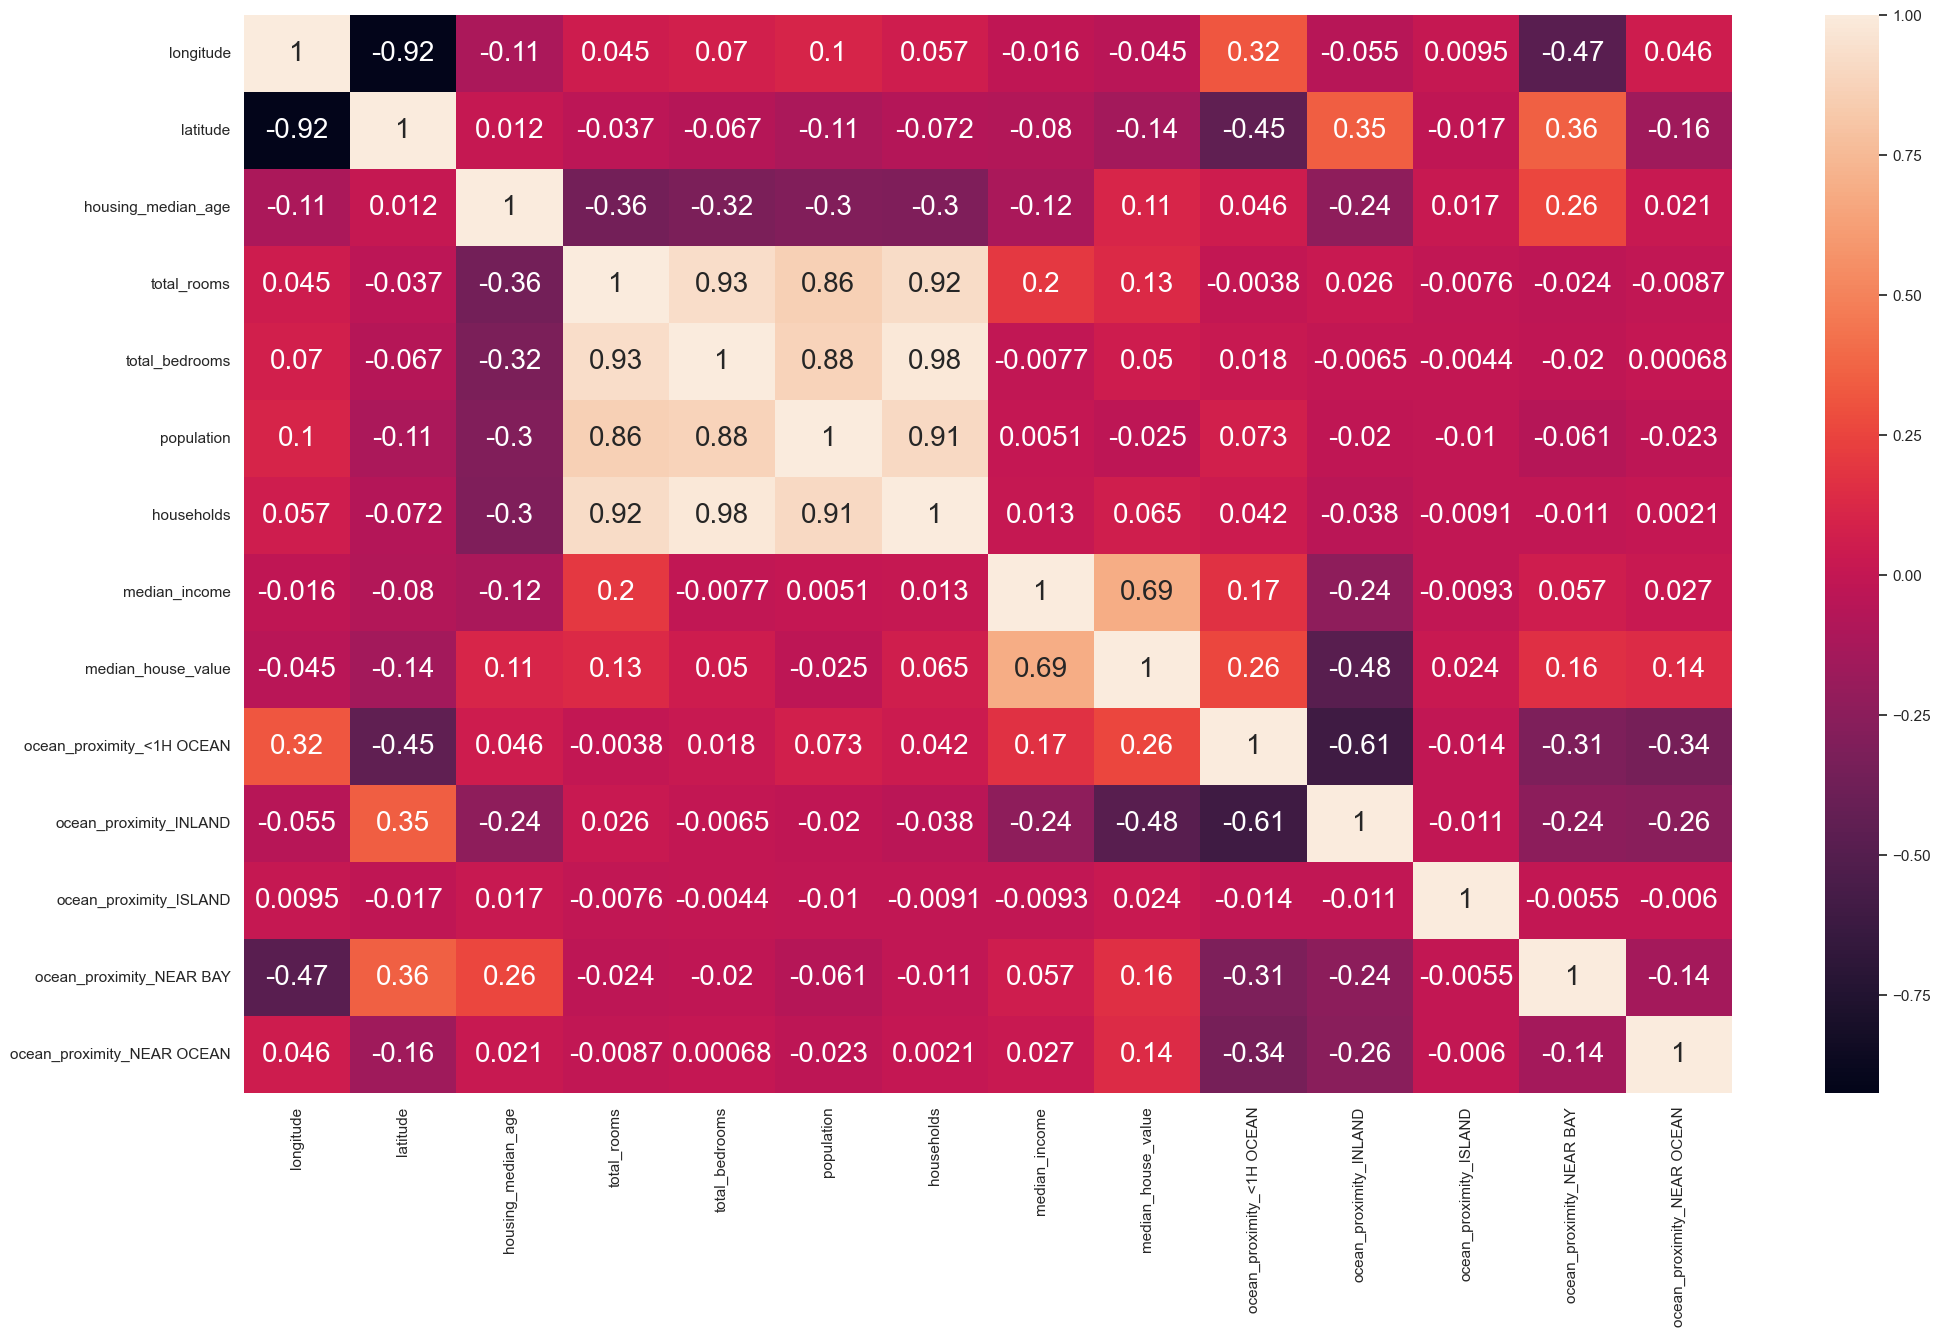

In [39]:
# housing dataset correlation in heat map
housing_dataset_correlation = california_housing.corr()
plt.figure(figsize=(24,14))
sns.heatmap(housing_dataset_correlation, annot = True)



Valor óptimo de max_features: 8


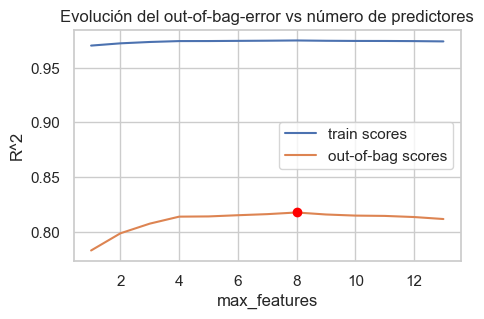

In [40]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

##### Grid search

Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, ya que cada hiperparámetro interacciona con los demás. Es preferible recurrir a grid search o random search para analizar varias combinaciones de hiperparámetros.

<div >
<img src = "figures/gridsearch.png" />
</div>


In [42]:
from sklearn.model_selection import ParameterGrid


In [43]:
# Grid Search Aleatorio basado en validación cruzada
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold


# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [100,150,200],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid_forest_cv = RandomizedSearchCV(
            estimator  = RandomForestRegressor(random_state = 123),
            param_distributions = param_grid,
            scoring    = 'neg_root_mean_squared_error',
            n_jobs     = multiprocessing.cpu_count() - 1,
            n_iter=2, 
            cv=5, 
            random_state=42,
            refit=True
       )

grid_forest_cv.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_forest_cv.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)


# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid_forest_cv.best_params_, ":", grid_forest_cv.best_score_, grid_forest_cv.scoring)


----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'n_estimators': 200, 'max_features': 9, 'max_depth': 20} : -49756.20902342359 neg_root_mean_squared_error


Una vez identificados los mejores hiperparámetros, se reentrena el modelo indicando los valores óptimos en sus argumentos. Si en el GridSearchCV() se indica refit=True, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_.

In [44]:
# Error de test del modelo final
# ==============================================================================
modelo_grid_forest_cv_final = grid_forest_cv.best_estimator_
predicciones_grid_forest_cv_final = modelo_grid_forest_cv_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones_grid_forest_cv_final,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 48595.6005653653


# Boosting Trees

In [45]:
db = pd.read_csv("https://raw.githubusercontent.com/ignaciomsarmiento/datasets/main/boosting_tree_toy.csv")

db.head()

,Unnamed: 0,x,y
0,1,0.082169,0.194623
1,2,0.084134,0.079395
2,3,0.146594,0.066553
3,4,0.174592,-0.058635
4,5,0.223308,-0.150408


In [46]:
y=db['y']
x=db['x']

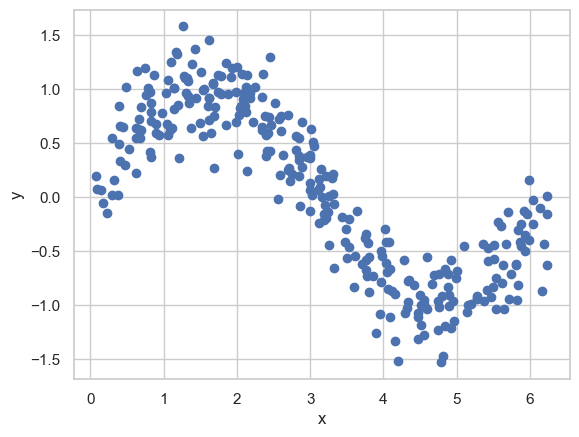

In [47]:
plt.scatter(x, y)

# Adding labels and title for clarity
plt.xlabel('x')
plt.ylabel('y')

# Show the plot
plt.show()

In [48]:
x=db['x'].to_numpy().reshape(-1, 1)

### Hiperparámetros

- $\lambda$ la tasa a la que aprende, los valores típicos son 0.1, 0.01 o 0.001

In [49]:
lam =0.01

- Tamaño del árbol. Arboles pocos profundos  funcionan bien.

In [50]:
d=1 #stump

- Iniciamos fijando $\hat{f}(x)=0$ y $r_i=y_i$ para todos los $i$ del training set

In [51]:
fhat = np.zeros(len(y))

r=y

In [52]:
y.head()

0    0.194623
1    0.079395
2    0.066553
3   -0.058635
4   -0.150408
Name: y, dtype: float64

In [53]:
r.head()

0    0.194623
1    0.079395
2    0.066553
3   -0.058635
4   -0.150408
Name: y, dtype: float64

Para $m=1,2,...,M$

 - Ajustamos un árbol $\hat{f}^m$ con $d$ bifurcaciones ($d+1$ hojas)

In [54]:
#Primera iteración
model = DecisionTreeRegressor(max_depth=d, random_state=12)
model.fit(x, r)

  # Make predictions
yhat1 = model.predict(x)


lam *yhat1

array([ 0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,
        0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,
        0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,
        0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,
        0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,
        0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,
        0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,
        0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,
        0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,
        0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,
        0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,
        0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,
        0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,
        0.0068034 ,  0.0068034 ,  0.0068034 ,  0.0068034 ,  0.00

   - Actualizamos $\hat{f}(x)$ con una versión "shrunken" del nuevo árbol

In [55]:
f1=fhat + lam *yhat1

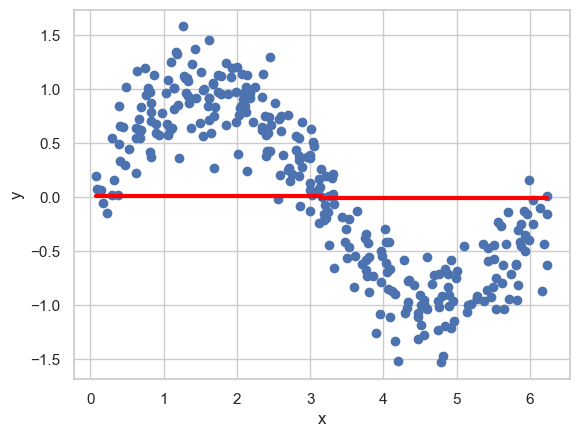

In [56]:
# Create a scatter plot of x vs y
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')

# Add a step line plot of x vs f1
plt.step(x, f1, where='mid', color='red', linewidth=3)

# Show the plot
plt.show()

- Actualizamos los residuales
  \begin{align}
  r_i\leftarrow r_i-\lambda\hat{f}^m(x)
  \end{align}

In [57]:
# Calculate errors
r1 = r - lam*yhat1

El loop vuelve a iniciar, en la iteración 2:

In [58]:
# iteracion 2

model.fit(x, r1)

  # Make predictions
yhat2 = model.predict(x)



f2 = f1 + lam *yhat2

    

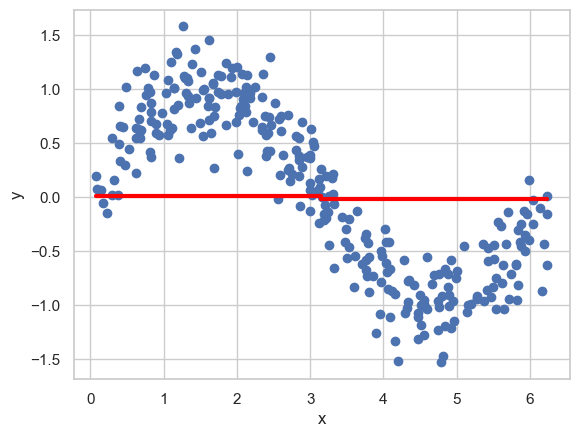

In [59]:
# Plot
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.step(x, f2, where='mid', color='red', linewidth=3)

plt.show()

In [60]:
# En un loop
# Initialize fhat and residuals (r)
fhat = np.zeros(len(y))
r = y.copy()

# Set lambda (adjust as needed)
lambda_ = 0.1

# Initialize YP with lambda * fhat
YP = lambda_ * fhat.reshape(-1, 1)

In [61]:
for t in range(500):
    # Fit a decision tree regressor
    fit = DecisionTreeRegressor(max_depth=1)
    fit.fit(x.reshape(-1, 1), r)

    # Predict using the fitted model
    yhat = fit.predict(x.reshape(-1, 1))

    # Update residuals
    r = r - lambda_ * yhat

    # Update YP
    YP = np.hstack((YP, (lambda_ * yhat).reshape(-1, 1)))


In [64]:
M = 300
fhat = np.apply_along_axis(np.sum, 1, YP[:, :M])

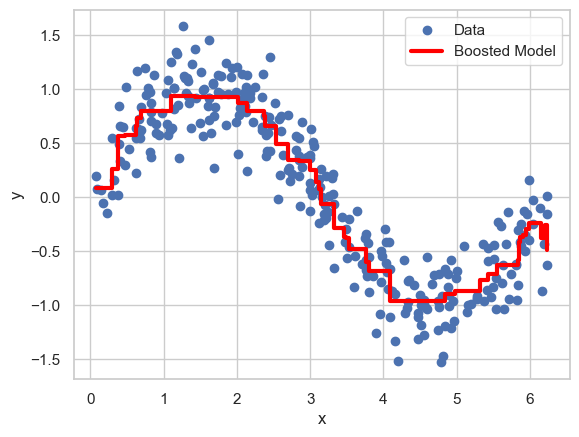

In [65]:
# Scatter plot of x vs y
plt.scatter(x, y, label='Data')

# Step plot of x vs fhat
plt.step(x, fhat, where='mid', color='red', linewidth=3, label='Boosted Model')

# Setting labels and showing the plot
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


## Con los datos de California Housing

In [66]:
from sklearn.ensemble import HistGradientBoostingRegressor

# Creación del modelo
# ==============================================================================
modelo_boost = HistGradientBoostingRegressor(
            max_iter     = 600,
            loss         = 'squared_error',
            random_state = 123
         )

# Entrenamiento del modelo
# ==============================================================================
modelo_boost.fit(X_train, y_train)

HistGradientBoostingRegressor(max_iter=600, random_state=123)

In [68]:
?HistGradientBoostingRegressor

In [67]:


# Error de test del modelo inicial
# ==============================================================================
predicciones_boost = modelo_boost.predict(X = X_test)

rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones_boost,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")



El error (rmse) de test es: 46727.97343777038


In [ ]:
Sqrt(Mean((Precio-Precio_predicho)^2))


#### Ajuste del modelo, Hiperparámetros y Grid Search basado en validación cruzada

Puede encontrarse una descripción detallada de todos ellos en sklearn.ensemble.GradientBoostingRegressor. En la práctica, cabe prestar especial atención a aquellos que controlan el crecimiento de los árboles, la velocidad de aprendizaje del modelo, y los que gestionan la parada temprana para evitar overfitting:

   - `learning_rate`: tasa a la que aprende

   - `max_iter`: número de árboles incluidos en el modelo.

   - `max_depth`: profundidad máxima que pueden alcanzar los árboles.

   - `random_state`: semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.


In [69]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'learning_rate'    : [0.001, 0.01,0.1],
              'max_depth'        : [1,3, 5],
              'max_iter'         : [100, 300,500]
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = HistGradientBoostingRegressor(
                        random_state        = 42,
                        scoring             = 'loss',
                    ),
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=3, n_repeats=1, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)


GridSearchCV(cv=RepeatedKFold(n_repeats=1, n_splits=3, random_state=123),
             estimator=HistGradientBoostingRegressor(random_state=42), n_jobs=7,
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [1, 3, 5], 'max_iter': [100, 300, 500]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [70]:

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
   

,param_learning_rate,param_max_depth,param_max_iter,mean_test_score,std_test_score,mean_train_score,std_train_score
26,0.1,5,500,-47556.046291,677.721739,-30554.711908,271.979383
25,0.1,5,300,-47941.553069,694.898447,-34981.985812,253.182938
23,0.1,3,500,-49065.831360,915.194848,-42305.969632,64.560966
22,0.1,3,300,-50314.943012,1058.039164,-45357.434054,170.683710
24,0.1,5,100,-50417.378015,995.298140,-43605.789452,310.758755
17,0.01,5,500,-53936.072999,932.942362,-49643.960571,326.878753
21,0.1,3,100,-55141.716233,1011.046072,-52786.608645,363.474062
16,0.01,5,300,-59342.573722,866.475495,-56285.462306,375.023356
14,0.01,3,500,-61400.110406,984.602224,-60023.541635,380.702013
20,0.1,1,500,-62447.352433,667.776956,-61432.821763,243.072719


In [71]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
        squared = False
       )
print(f"El error (rmse) de test es: {rmse}")



El error (rmse) de test es: 47599.81414499026
